In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Dependancies

In [2]:
### Data handling libraries ###

import numpy as np
import pandas as pd
import os

### Plotting Libraries ### 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

### Date Time ###

import datetime
import time
import pytz

### Warnings ###
import warnings
warnings.filterwarnings('ignore')

### Progress Bar ###
from tqdm import tqdm

### Model Building, Model Evaluvation, Model Preprocessing ###

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# Models Imbalance # 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# ML MODELS #

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

# Scoring Dependancies #

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
# from sklearn.metrics import average_precision_score,make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, KFold
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

# Models Saving #

import pickle

# Other #
from collections import Counter
from sklearn.utils import shuffle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Constants

In [3]:
PATH = r'/content/gdrive/My Drive/MLPipeLine'
READFILE = 'investments_VC.csv'
ROWS = 0
COLUMNS = 0
SEARCHFIT = 0
LISTCOLUMNNAME= []
LISTFUNDINGCOL = ['seed', 'venture',
       'equity_crowdfunding', 'undisclosed', 'convertible_note',
       'debt_financing', 'grant', 'private_equity', 'post_ipo_equity',
       'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A',
       'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G',
       'round_H']

MAINDF = pd.read_csv(os.path.join(PATH, READFILE), encoding='latin1')
LISTCOLUMNNAME = list(MAINDF.columns)
ROWS, COLUMNS = MAINDF.shape

# Functions

In [4]:
def funcCustomCVScore(fncp_X_train, fncp_y_train, fncpKFold,fncpBaseModel, fncpBaseModelParam=None, fncpRandomState=123, fncpScoreAverage='weighted'):

  '''
  This function splits the X_train and y_train into folds for cross calulating recall, precesion and f1 score's of each fold and returns the scores 
  and prints the mean score and the 95% confidence interval of the score estimate.

  input:
     fncp_X_train - X_train
     fncp_y_train - y_train
     fncpKFold - No of folds
     fncpBaseModel - Base model. Ex: RandomForestClassifier
     (Optional) (dict) - Parameters to be used in the base model
     (Optional)  fncpRandomState
     (Optional) fncpScoreAverage
  output:
    recallScores
    precisionScores
    f1Scores

  '''
  kfold = KFold(n_splits=fncpKFold, random_state=fncpRandomState)
  recallScores = []
  precisionScores = []
  f1Scores = []
  for train_index, test_index in tqdm(kfold.split(fncp_X_train)):
    cv_X_train = fncp_X_train[fncp_X_train.index.isin(train_index)]
    cv_X_test = fncp_X_train[fncp_X_train.index.isin(test_index)]

    cv_y_train = fncp_y_train[fncp_y_train.index.isin(train_index)]
    cv_y_test = fncp_y_train[fncp_y_train.index.isin(test_index)]

    if fncpBaseModelParam == None:
      model = fncpBaseModel()
    else:
      model = fncpBaseModel(**fncpBaseModelParam)
    model.fit(cv_X_train,cv_y_train)

    tempScore = round(recall_score(cv_y_test, model.predict(cv_X_test), average=fncpScoreAverage)*100,2)
    precisionScores.append(tempScore)

    tempScore = round(precision_score(cv_y_test, model.predict(cv_X_test), average=fncpScoreAverage)*100,2)
    recallScores.append(tempScore)

    tempScore = round(f1_score(cv_y_test, model.predict(cv_X_test), average=fncpScoreAverage)*100,2)
    f1Scores.append(tempScore)
  print('\n')
  print(f'The mean score and the 95% confidence interval of the score estimate are')
  print("Recall: %0.2f (+/- %0.2f)" % (np.array(recallScores).mean(), np.array(recallScores).std() * 2))
  print("Precision: %0.2f (+/- %0.2f)" % (np.array(precisionScores).mean(), np.array(precisionScores).std() * 2))
  print("F1-Score: %0.2f (+/- %0.2f)" % (np.array(f1Scores).mean(), np.array(f1Scores).std() * 2))
  return recallScores, precisionScores, f1Scores

In [5]:
def funcCustomCVScore(fncp_X_train, fncp_y_train, fncpKFold,fncpBaseModel, fncpBaseModelParam=None, fncpRandomState=123, fncpScoreAverage='weighted'):

  '''
  This function splits the X_train and y_train into folds for cross calulating recall, precesion and f1 score's of each fold and returns the scores 
  and prints the mean score and the 95% confidence interval of the score estimate.

  input:
     fncp_X_train - X_train
     fncp_y_train - y_train
     fncpKFold - No of folds
     fncpBaseModel - Base model. Ex: RandomForestClassifier
     (Optional) (dict) - Parameters to be used in the base model
     (Optional)  fncpRandomState
     (Optional) fncpScoreAverage
  output:
    recallScores
    precisionScores
    f1Scores

  '''
  kfold = KFold(n_splits=fncpKFold, random_state=fncpRandomState)
  recallScores = []
  precisionScores = []
  f1Scores = []
  for train_index, test_index in tqdm(kfold.split(fncp_X_train)):
    cv_X_train = fncp_X_train[fncp_X_train.index.isin(train_index)]
    cv_X_test = fncp_X_train[fncp_X_train.index.isin(test_index)]

    cv_y_train = fncp_y_train[fncp_y_train.index.isin(train_index)]
    cv_y_test = fncp_y_train[fncp_y_train.index.isin(test_index)]

    if fncpBaseModelParam == None:
      model = fncpBaseModel()
    else:
      model = fncpBaseModel(**fncpBaseModelParam)
    model.fit(cv_X_train,cv_y_train)

    tempScore = round(recall_score(cv_y_test, model.predict(cv_X_test), average=fncpScoreAverage)*100,2)
    precisionScores.append(tempScore)

    tempScore = round(precision_score(cv_y_test, model.predict(cv_X_test), average=fncpScoreAverage)*100,2)
    recallScores.append(tempScore)

    tempScore = round(f1_score(cv_y_test, model.predict(cv_X_test), average=fncpScoreAverage)*100,2)
    f1Scores.append(tempScore)
  print('\n')
  print(f'The mean score and the 95% confidence interval of the score estimate are')
  print("Recall: %0.2f (+/- %0.2f)" % (np.array(recallScores).mean(), np.array(recallScores).std() * 2))
  print("Precision: %0.2f (+/- %0.2f)" % (np.array(precisionScores).mean(), np.array(precisionScores).std() * 2))
  print("F1-Score: %0.2f (+/- %0.2f)" % (np.array(f1Scores).mean(), np.array(f1Scores).std() * 2))
  return recallScores, precisionScores, f1Scores

In [36]:
def funcPreprocessing(fncpDF):
    
    '''
    This function
    1) Removes leading and trailing white spaces in the column names.
    2)Removes leading and trailing white spaces in the values present in object datatype columns.
    
    input
        Dataframe
    output
        None
    '''

    dictCol = {}
    print('Column preprocessing...')
    for col in fncpDF.columns:
        dictCol[col] = col.strip()
    fncpDF.rename(columns=dictCol, inplace=True) 
    print('Object datatype preprocessing...\n')
    for col in fncpDF.columns:
        if fncpDF[col].dtype == 'object':
            fncpDF[col] = fncpDF[col].str.strip()
    print('Sucessfully preprocessed the dataframe!')   

In [7]:
def fncpModelEvaluvate(fncpActual, fncpPredicted, fncpBoolHeatMap=False, fncpMultiClass=True,fncpAverageType='weighted'):
  '''
  This function prints the various evaluvation metric of a models and also prints the confusion matrix
  input:
    fncpActual - Actual Values
    funPredictedValues - Predicted Values
    (optional) (bool) fncpBoolHeatMap - To display or not display confusion matrix
    (optional) (bool) fncpMultiClass - Is it a multiclass problem or binary class problem
    (optional) (bool) fncpAverageType - Average type for multiclass problem   
  '''

  # Heat Map #
  if  fncpBoolHeatMap == True:
    cf_matrix = confusion_matrix(fncpActual, fncpPredicted)
    make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=True, cmap='BrBG')
    print('\n\n')

  print('Evaluation Metrics\n')
  # print(f'Accuracy Score :{round(accuracy_score(fncpActual, fncpPredicted)*100,2)}%')
  if fncpMultiClass == True:
    print(f'Recall Score :{round(recall_score(fncpActual, fncpPredicted, average=fncpAverageType)*100,2)}%')
    print(f'Precision Score :{round(precision_score(fncpActual, fncpPredicted, average=fncpAverageType)*100,2)}%')
    print(f'F1 Score :{round(f1_score(fncpActual, fncpPredicted, average=fncpAverageType)*100,2)}%')
  else:
    print(f'Recall Score :{round(recall_score(fncpActual, fncpPredicted)*100,2)}%')
    print(f'Precision Score :{round(precision_score(fncpActual, fncpPredicted)*100,2)}%')
    print(f'F1 Score :{round(f1_score(fncpActual, fncpPredicted)*100,2)}%')


In [8]:
def funcFeatureImportance(fncpModel, fncpTrainSet, fncpCV=True):

  '''
  This function prints the top 20 and bottom 20 important features and returns an dataframe with important features sorted in descending order
  input:
    (model) fncpModel
    (dataframe) fncpTrainSet
    (optional) (bool) fncpCV
  ouput:
    dataframe
  '''
  if fncpCV == True:
    feature_importances = pd.DataFrame(fncpModel.best_estimator_.feature_importances_,
                                      index = fncpTrainSet.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
  else:
    feature_importances = pd.DataFrame(fncpModel.feature_importances_,
                              index = fncpTrainSet.columns,
                                columns=['importance']).sort_values('importance', ascending=False)                         
  print("Top 20 Important Feature\n")
  print(feature_importances.head(20))
  print('\n')
  print("Bottom 20 Important Feature\n")
  print(feature_importances.tail(20))
  return feature_importances

In [9]:
def funcDescription(fncpDF, fncpPrnt=False):
    
    '''
    This function prints some of the general characterstics of the dataset and returns a list of tuples about the columns.
    input: 
        DataFrame
        (bool) (optional) To print or not
    output: 
        List of general characterstics
    '''
    
    lstTemp = []
    for col in tqdm(fncpDF.columns):
        if fncpDF[col].dtype == 'object':
            colUniqueValue = fncpDF[col].nunique()
            colMax = 0
            colMin = 0
            colMean = 0
            colType = 'object'
            lstTemp.append((col.strip(), colUniqueValue, colMax,colMin,round((fncpDF[col].isna().sum()/ROWS)*100, 2), colType))
        else:
            colUniqueValue = 0
            colMax = fncpDF[col].max()
            colMin = fncpDF[col].min()
            colMean = round(fncpDF[col].mean(),2)
            colType = 'float'
            lstTemp.append((col, colUniqueValue, colMax,colMin,round((fncpDF[col].isna().sum()/ROWS)*100, 2), colType))           
    lstTemp = sorted(lstTemp, key=lambda x: x[4], reverse=True)
    if fncpPrnt:
        print(f'Total no of rows : {fncpDF.shape[0]} \nTotal no of columns : {fncpDF.shape[1]}')
        totalNaNRows = fncpDF[fncpDF.isna().any(axis=1)].shape[0]
        print(f'Rows with atleast one of the columns with a NaN value : {totalNaNRows}')
        print('\n')
        for item in lstTemp:
            print(f'------------------- {item[0]}-------------------')
            print(f'Unique values in column : {item[1]}')
            print(f'Max value in column : {item[2]}')
            print(f'Min value in column : {item[3]}')
            print(f'Mean Value in column : {item[4]}')
            print('\n')
    return lstTemp

In [10]:
### Date preprocessing ###

def funcDateManipulation(fncpDF, fncpColName, funcStartsWith='00'):
    '''
    The expected date format is yyyy-mm-dd but few of the dates are not in this format. This function changes the value to the / 
    specified format. The startsWith searches for all the dates that begin with 00 and modifies them into the required format.
    
    input: 
        DataFrame
        (str) fncpColName, 
        (str) (optional) funcStartsWith
    output: 
        None
    '''
    print(f'Processing column {fncpColName}....')
    lstTemp = fncpDF.loc[fncpDF[fncpColName].str.startswith(funcStartsWith, na=False), [fncpColName]].values.tolist()
    print(lstTemp)
    for dte in lstTemp:
        year = str(dte[0][-2:])
        month = str(dte[0][5:7])
        day = str(dte[0][2:4])
        newDate = '20'+year+'-'+month+'-'+day
        fncpDF.loc[fncpDF[fncpColName].str.contains(dte[0], na=False),[fncpColName]] = newDate
    print(f'Sucessfully changed the date for {fncpColName} variable')

In [11]:
def funcCustomOneHotEncode(fncpDF, fncpColName,fncpTop=5, fncpBottom=5, fncpMiddle=10, fncpDropOriginal=True):
    
    '''
    This function takes the fncpTop, fncpMiddledle and fncpBottom most occuring values in a feature and one hot encodes the values.
    input: 
        DataFrame, 
        (str) Variable/Feature,
        (int) (optional) fncpTop n categories, 
        (int) (optional) fncpBottom n categories, 
        (int) (optional) fncpMiddle n categories, 
        (bool) (optional) To drop original variable
    output: 
        1 (Success) 
        -1 (Failure)
    '''
    
    if fncpColName not in fncpDF.columns:
        return -1
    
    uniqueMarketsCount = len(fncpDF[fncpColName].unique())
    print(f'There are in total {uniqueMarketsCount} unique categories in {fncpColName} feature \n')

    # Top X
    listfncpTopXCategories = []
    listfncpTopXCategories = fncpDF[fncpColName].value_counts().sort_values(ascending = False).head(fncpTop).index.tolist()
    if 'Unknown' in listfncpTopXCategories:
        listfncpTopXCategories = fncpDF[fncpColName].value_counts().sort_values(ascending = False).head(fncpTop + 1).index.tolist()
        listfncpTopXCategories.remove('Unknown') # Removing the 'Unknown' market since it is a imputed value
    print(f'fncpTop {len(listfncpTopXCategories)} markets are:\n ')
    print({*listfncpTopXCategories}, sep = ", ")

    # Mid X
    listfncpMiddleXCategories = []
    startPos = int(uniqueMarketsCount/2)
    endPos = startPos + fncpMiddle
    listfncpMiddleXCategories = fncpDF[fncpColName].value_counts().sort_values(ascending = True)[startPos:endPos].index.tolist()
    if 'Unknown' in listfncpMiddleXCategories:
        listfncpMiddleXCategories = fncpDF[fncpColName].value_counts().sort_values(ascending = True)[startPos:endPos + 1].index.tolist()        
        listfncpMiddleXCategories.remove('Unknown') # Removing the 'Unknown' market since it is a imputed value
    print(f'\nfncpMiddle {len(listfncpMiddleXCategories)} markets are:\n ')
    print({*listfncpMiddleXCategories}, sep = ", ")

    # Bottom X
    listfncpBottomXCategories = []
    listfncpBottomXCategories = fncpDF[fncpColName].value_counts().sort_values(ascending = True).head(fncpBottom).index.tolist()
    if 'Unknown' in listfncpTopXCategories:
        listfncpBottomXCategories = fncpDF[fncpColName].value_counts().sort_values(ascending = True).head(fncpBottom + 1).index.tolist()
        listfncpBottomXCategories.remove('Unknown') # Removing the 'Unknown' market since it is a imputed value
    print(f'\nfncpBottom {len(listfncpBottomXCategories)} markets are:\n ')
    print({*listfncpBottomXCategories}, sep = ", ")

    listFinalXCategories = listfncpTopXCategories + listfncpMiddleXCategories + listfncpBottomXCategories
    for label in listFinalXCategories:
      fncpDF['f_'+fncpColName+'_'+label] = np.where(fncpDF[fncpColName] == label,1,0)
    
    if fncpDropOriginal == True:
        fncpDF.drop(fncpColName, axis=1, inplace=True)
    print(f'Sucessfully implemented custom one hot encoding for {fncpColName} variable...')
    return listFinalXCategories

In [12]:
def funcColumnsToDrop(fncpDF, fncpLstColToDrop = []):
    
    '''
    This function drops a list of column(s) in the dataframe and returns the new unique columns in the dataframe
    input: Dataframe, list of coulumns to drop
    output: list of new columns (Sucess) / -1 (Failure)
    '''
    
    if len(fncpLstColToDrop) > 0 and set(fncpLstColToDrop).issubset(fncpDF.columns):
        fncpDF.drop(fncpLstColToDrop, axis=1, inplace=True) 
        return fncpDF.columns
    else:
        print('No columns to drop or one of the columns present in the list is not available in the dataframe')
        return -1

In [27]:
def funcHeatMap(funcpX, funcpY, funcpSize):
  '''
  This function creates a custom heatmap.
  Please refer https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec for in depth explanation of this function.
  '''

  fig, ax = plt.subplots()
  
  # Mapping from column names to integer coordinates
  x_labels = [v for v in sorted(funcpX.unique())]
  y_labels = [v for v in sorted(funcpY.unique())]
  x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
  y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
  
  size_scale = 270
  ax.scatter(
      x=funcpX.map(x_to_num), # Use mapping for x
      y=funcpY.map(y_to_num), # Use mapping for y
      s=funcpSize * size_scale, # Vector of square sizes, proportional to size parameter 
      c='green',
      alpha=0.8,
      marker='s' # Use square as scatterplot marker
  )
  
  # Show column labels on the axes
  ax.set_xticks([x_to_num[v] for v in x_labels])
  listTempXLabel = [name.replace('_', ' ') for name in x_labels]
  ax.set_xticklabels(listTempXLabel, rotation=90, horizontalalignment='right')
  ax.set_yticks([y_to_num[v] for v in y_labels])
  listTempYLabel = [name.replace('_', ' ') for name in y_labels]
  ax.set_yticklabels(listTempYLabel)
  ax.tick_params(axis='x', colors='white',labelsize=12)
  ax.tick_params(axis='y', colors='white')
  ax.grid(False, 'major')
  ax.grid(True, 'minor')
  ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
  ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
  ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
  ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

# Data Preprocessing

#### Strippping white spaces

In [62]:
### Renaming the columns to remove the white spaces ###    
dfProcessed = MAINDF.copy()
funcPreprocessing(dfProcessed)
LISTCOLUMNNAME = dfProcessed.columns

Column preprocessing...
Object datatype preprocessing...

Sucessfully preprocessed the dataframe!


#### Dropping Rows and Columns ###


In [63]:
### Checking and deleting rows where all the values are NaN ###

allNAValues = dfProcessed[dfProcessed.isna().all(axis=1)].shape[0]
print(f'There are {allNAValues} rows that have only NaN as values')
dfProcessed = dfProcessed.dropna(how='all')
dfProcessed = dfProcessed.reset_index(drop=True)

There are 4856 rows that have only NaN as values


In [64]:
### Checking duplicate records in a dataframe ###

duplicateRecords = dfProcessed[dfProcessed.duplicated()].shape[0]
if duplicateRecords == 0:
  print(f'There are {duplicateRecords} duplicate records in the dataframe')
else:
  print(f'{duplicateRecords} duplicate records are dropped from the dataframe')
  dfProcessed = dfProcessed[~dfProcessed.duplicated()]

There are 0 duplicate records in the dataframe


In [65]:
### Dropping rows where target variable 'status' is NaN ### 

targetNAValues = dfProcessed.loc[dfProcessed['status'].isna() == True,].shape[0]
print(f'There are {targetNAValues} rows for which target variable has NaN as values')
dfProcessed = dfProcessed.loc[dfProcessed['status'].isna() == False,]

There are 1314 rows for which target variable has NaN as values


In [66]:
### Removing the rows for which we dont have total funding and the breakup of the funding is null as well ###

print('The list of variables associated with funding are \n', LISTFUNDINGCOL)
dfProcessed['f_SumCol'] = dfProcessed[LISTFUNDINGCOL].sum(axis = 1)
rowsTotalSumCheck = dfProcessed.loc[(dfProcessed['funding_total_usd'] == '-'),['funding_total_usd']].shape[0]
print(f'There are {rowsTotalSumCheck} rows whose total funding is none ("-")')
rowsTotalSumCheck = dfProcessed.loc[(dfProcessed['funding_total_usd'] == '-') & (dfProcessed['f_SumCol'] > 0),].shape[0]
print(f'There are {rowsTotalSumCheck} rows whose total funding is none but sum of the total funding is more than zero')

### Selecting only the rows for which the variable funding_total_usd is not equal to '-' ###
dfProcessed = dfProcessed.loc[~(dfProcessed['funding_total_usd'] == '-'),]

The list of variables associated with funding are 
 ['seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']
There are 8322 rows whose total funding is none ("-")
There are 0 rows whose total funding is none but sum of the total funding is more than zero


In [67]:
# ### ROWS WITH HIGH NaN percetage ###

lstHighNanRow = []
for i in tqdm(range(len(dfProcessed.index)), desc='Rows processed'):
    temp = round((dfProcessed.iloc[i].isnull().sum()/dfProcessed.shape[1])*100,2)
    if temp >= 80:
      lstHighNanRow.append(i)
print(f'\nNumber of rows deleted is {len(lstHighNanRow)}')
dfProcessed = dfProcessed.drop(dfProcessed.index[lstHighNanRow])

Rows processed: 100%|██████████| 39802/39802 [00:19<00:00, 2041.39it/s]


Number of rows deleted is 0


In [68]:
### Removing permalink and name since this would not contribute to the model ###

lstDropColumns = ['permalink', 'name']
LISTCOLUMNNAME = funcColumnsToDrop(dfProcessed, lstDropColumns)

In [69]:
### Dropping region based columns ###

# Replacing Nan with 'Unknown' where all the region based columns have NaN values 
lstcolumns = ['country_code', 'state_code','region', 'city']
dfProcessed.loc[(dfProcessed[lstcolumns].isna().all(axis=1) == True), lstcolumns] = 'Unknown'

txt = 'Total Null values is '
print('country_code')
print(txt, dfProcessed[ 'country_code'].isnull().sum())
print('\n')
print('state_code')
print(txt, dfProcessed[ 'state_code'].isnull().sum())
print('\n')
print('region')
print(txt, dfProcessed[ 'region'].isnull().sum())
print('\n')
print('city')
print(txt, dfProcessed[ 'city'].isnull().sum())
print('\n')

print(dfProcessed.loc[(dfProcessed['state_code'].isnull() == False), lstcolumns]['country_code'].value_counts())

# Since the state_code has the maximum number of null values and remaing non-null values belong to US and Canada,
# we will be removing the state_code variable

lstDropColumns = ['state_code']
LISTCOLUMNNAME = funcColumnsToDrop(dfProcessed, lstDropColumns)

country_code
Total Null values is  0


state_code
Total Null values is  11039


region
Total Null values is  0


city
Total Null values is  635


USA        23995
Unknown     3663
CAN         1105
Name: country_code, dtype: int64


In [70]:
### Dropping City column ###

uniqueCityCount = len(dfProcessed['city'].unique())
uniqueRatioPercent = round(uniqueCityCount/len(dfProcessed['city'])*100,2)
print(f'There are {uniqueCityCount} unique cities and hence dropping the column since uniquness ratio is low ({uniqueRatioPercent})')
lstDropColumns = ['city']
LISTCOLUMNNAME = funcColumnsToDrop(dfProcessed, lstDropColumns)

There are 3536 unique cities and hence dropping the column since uniquness ratio is low (8.88)


In [71]:
### Removing funding_total_usd since this is just an addition of all the funding columns###

lstDropColumns = ['funding_total_usd'] #, 'f_SumCol']
LISTCOLUMNNAME = funcColumnsToDrop(dfProcessed, lstDropColumns)

### Combining Seed investment and Angel Investment into one since both are the same.

dfProcessed['seed'] = dfProcessed['seed'] + dfProcessed['angel']
lstDropColumns = ['angel']
LISTCOLUMNNAME = funcColumnsToDrop(dfProcessed, lstDropColumns)

# Exploratory Data Analysis



In [72]:
listColCharacterstics = funcDescription(MAINDF, fncpPrnt=False)

100%|██████████| 39/39 [00:00<00:00, 284.31it/s]


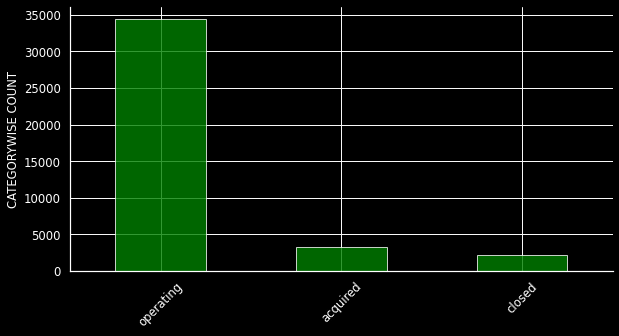

In [73]:
### Imbalanced Dataset ###


plt.figure(figsize = (10,5), facecolor = 'black', dpi=70) 
sns.set(rc={'axes.facecolor':'black', 
            'figure.facecolor':'black', 
            'axes.spines.top': False

            })
ax = dfProcessed['status'].value_counts(dropna = False).plot(kind='bar', color = 'green', alpha = 0.8)
ax.set_xlabel('')
ax.set_ylabel('CATEGORYWISE COUNT')
ax.set()
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white',labelsize=12)
ax.tick_params(axis='y', colors='white',labelsize=12)
ax.tick_params(axis='y', colors='white')
sns.despine()
plt.xticks(rotation=45)
plt.show()

['seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']


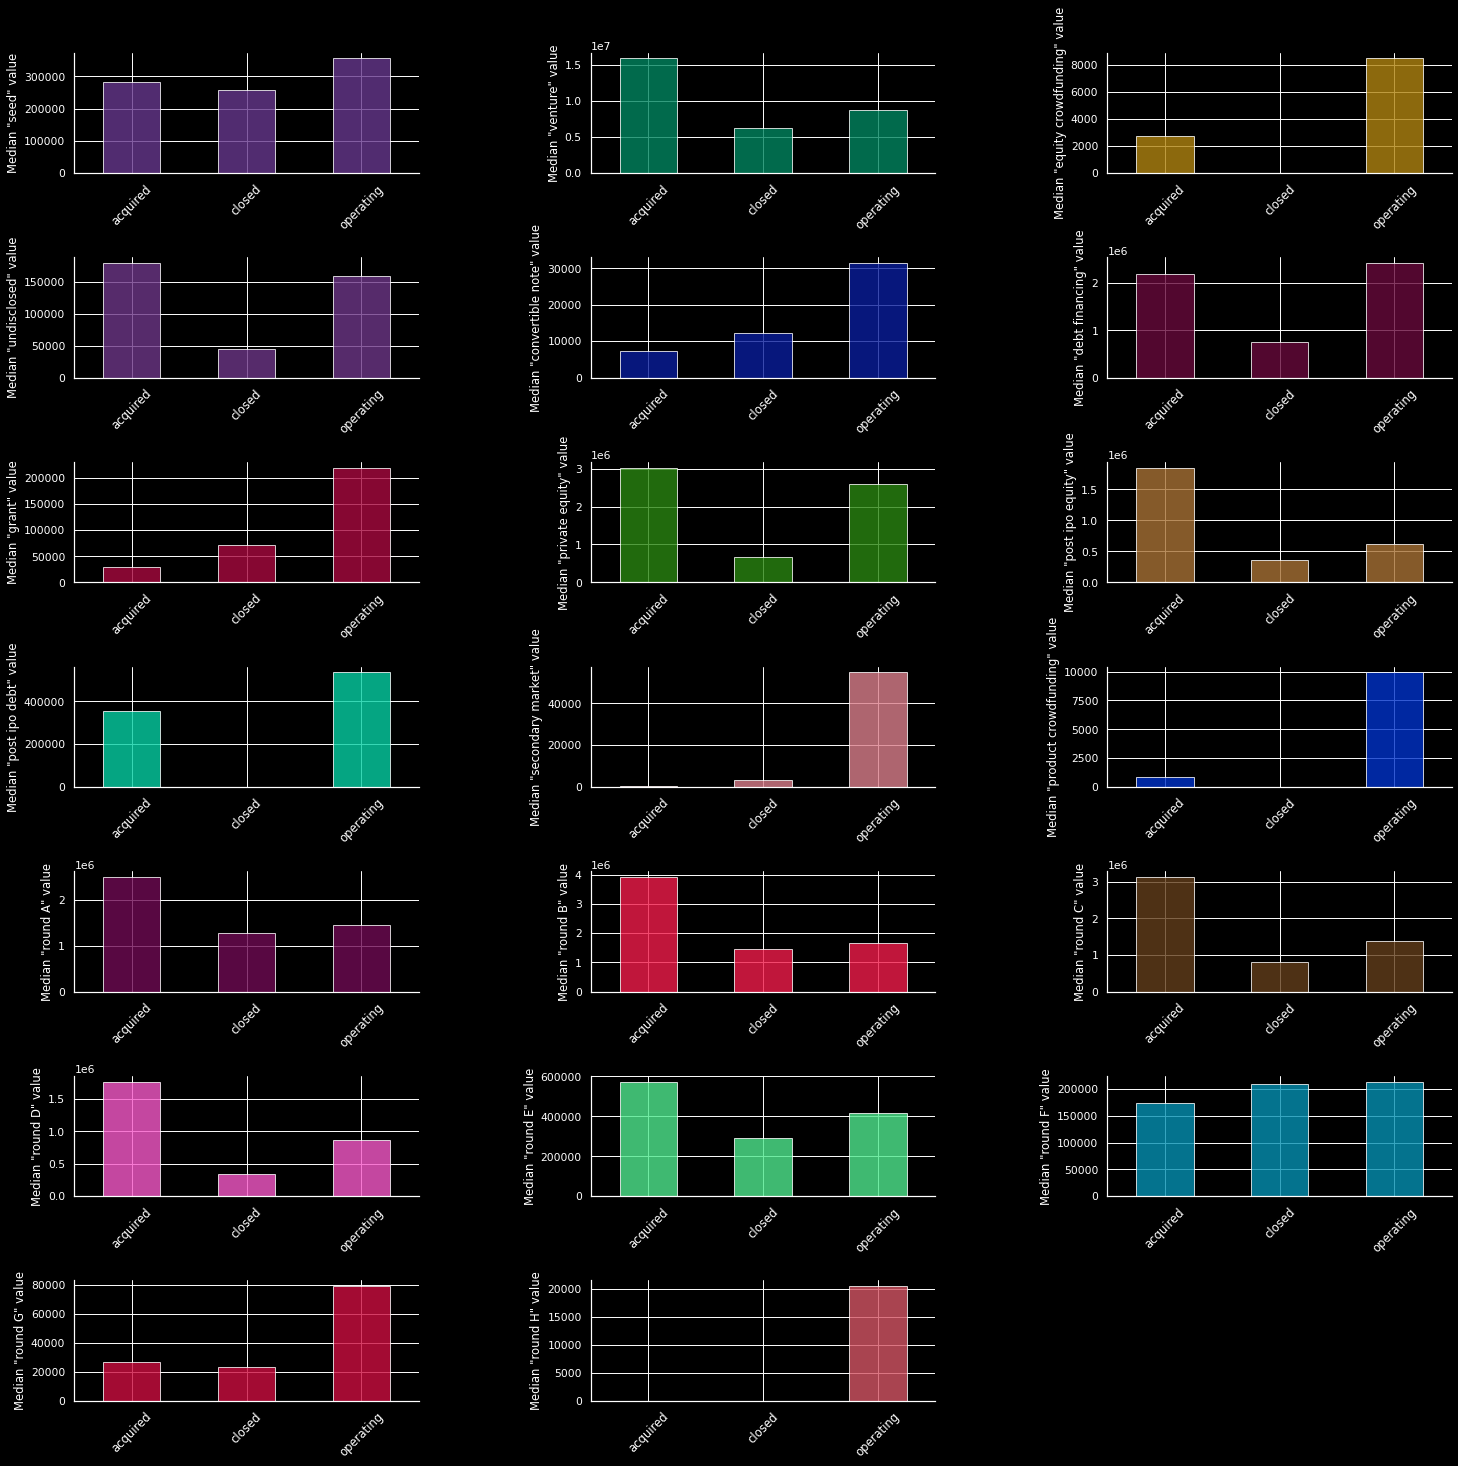

In [74]:
### Status VS Fundings ###

print(LISTFUNDINGCOL)

fig = plt.figure(figsize = (21,21), facecolor = 'black', dpi=70) 

for c,num in zip(LISTFUNDINGCOL, range(1,22)):
  ax = fig.add_subplot(7,3,num)
  x = np.random.rand()
  y = np.random.rand()
  z = np.random.rand()
  ax =  dfProcessed.groupby('status')[c].agg('mean').plot(kind='bar',alpha = .8, color=(x,y,z))

  ax.set_xlabel('')
  temp = 'Median "' + c.replace('_',' ') + '" value'
  ax.set_ylabel(temp)
  ax.set_title('')
  ax.xaxis.label.set_color('white')
  ax.yaxis.label.set_color('white')
  ax.tick_params(axis='x', colors='white',labelsize=12)
  ax.tick_params(axis='y', colors='white')
  sns.despine()
  plt.xticks(rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0.7, wspace = 0.5)

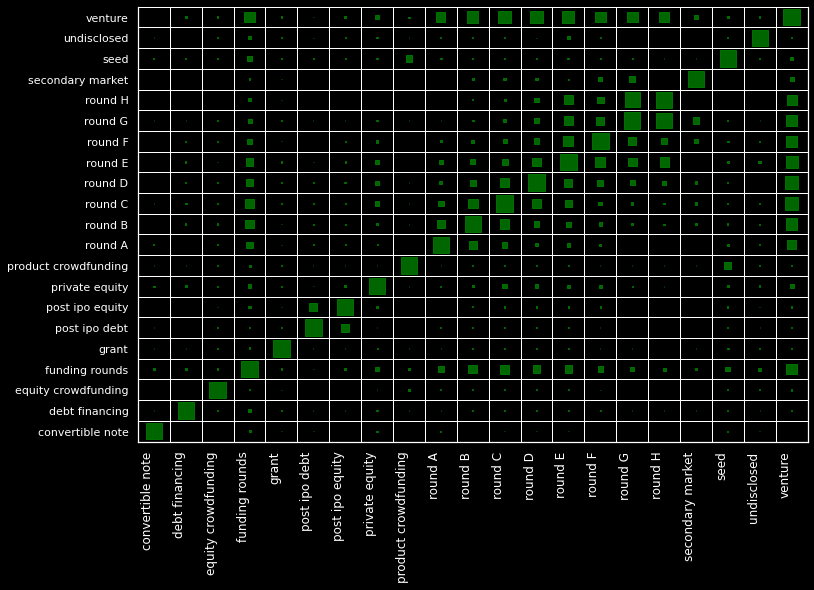

In [75]:
### Correlation HeatMap ###

listTempCol = LISTFUNDINGCOL.copy()
listTempCol.append('funding_rounds')
corr = dfProcessed[listTempCol].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
funcHeatMap(
    funcpX=corr['x'],
    funcpY=corr['y'],
    funcpSize=corr['value'].abs()
)

# Feature Engineering

#### Date variable


In [76]:
### Found out while converting the object type to date type ###

wrongDateCount = dfProcessed.loc[dfProcessed['founded_at'].str.contains('1636', na=False),].shape[0]
print(f'There are {wrongDateCount} record(s) whose year is 1636')
dfProcessed = dfProcessed.loc[~dfProcessed['founded_at'].str.contains('1636', na=False),]

There are 1 record(s) whose year is 1636


In [77]:
### List of years starting with '00'. This was found while trying to convert the the column datatyp to datetime ###

print(dfProcessed.loc[dfProcessed['first_funding_at'].str.startswith('00', na=False), ['first_funding_at']])
print('\n')
funcDateManipulation(dfProcessed, 'first_funding_at')
print('\n')
print(dfProcessed.loc[dfProcessed['last_funding_at'].str.startswith('00', na=False), ['last_funding_at']])
print('\n')
funcDateManipulation(dfProcessed, 'last_funding_at')

      first_funding_at
29695       0007-05-13
37313       0011-11-14


Processing column first_funding_at....
[['0007-05-13'], ['0011-11-14']]
Sucessfully changed the date for first_funding_at variable


Empty DataFrame
Columns: [last_funding_at]
Index: []


Processing column last_funding_at....
[]
Sucessfully changed the date for last_funding_at variable


In [78]:
# ## Found out while converting the object type to date type ###

dfProcessed.loc[dfProcessed['first_funding_at'].str.contains('201-01-01', na=False),['first_funding_at']] = '2010-01-01'
dfProcessed.loc[dfProcessed['last_funding_at'].str.contains('201-01-01', na=False),['last_funding_at']] = '2010-01-01'
print('Date sucessfully changed')

Date sucessfully changed


In [79]:
### Changing object type to date type ###

dfProcessed['founded_at'] = dfProcessed['founded_at'].astype('datetime64[ns]')
dfProcessed['first_funding_at'] = dfProcessed['first_funding_at'].astype('datetime64[ns]')
dfProcessed['last_funding_at'] = dfProcessed['last_funding_at'].astype('datetime64[ns]')

#### Market variable

In [80]:
### Market variable ###
 
dfProcessed['market'] = dfProcessed['market'].str.strip() 
marketNAValues = dfProcessed.loc[(dfProcessed['market'].isna() == True),].shape[0]
print(f'There are in total {marketNAValues} rows for which the market has NaN value')
dfProcessed.loc[(dfProcessed['market'].isna() == True),['market']] = 'Unknown' # Replacing NaN as UnKnown

There are in total 2215 rows for which the market has NaN value


In [81]:
### Market variable selecting only top 5, bottom 5 and mid 10 and one-hot encoding###

market_variableOneHotCol = funcCustomOneHotEncode(dfProcessed, 'market')

There are in total 735 unique categories in market feature 

fncpTop 5 markets are:
 
{'Biotechnology', 'E-Commerce', 'Software', 'Mobile', 'Curated Web'}

fncpMiddle 10 markets are:
 
{'3D Printing', 'Oil and Gas', 'Shipping', 'Identity Management', 'Polling', 'Product Design', 'Law Enforcement', 'Unifed Communications', 'Cooking', 'Computer Vision'}

fncpBottom 5 markets are:
 
{'Film Distribution', 'Fuels', 'Remediation', 'RIM', 'Timeshares'}
Sucessfully implemented custom one hot encoding for market variable...


#### Region Variables

In [82]:
### country_code variable selecting only top 5, bottom 5 and mid 10 and one-hot encoding###

country_code_variableOneHotCol = funcCustomOneHotEncode(dfProcessed, 'country_code')

There are in total 111 unique categories in country_code feature 

fncpTop 5 markets are:
 
{'FRA', 'GBR', 'CAN', 'USA', 'CHN'}

fncpMiddle 10 markets are:
 
{'DZA', 'PER', 'ROM', 'KEN', 'LUX', 'COL', 'LTU', 'PHL', 'ISL', 'NGA'}

fncpBottom 5 markets are:
 
{'MAF', 'CIV', 'JAM', 'SYC', 'MKD'}
Sucessfully implemented custom one hot encoding for country_code variable...


In [83]:
### region variable selecting only top 5, bottom 5 and mid 10 and one-hot encoding###

region_variableOneHotCol = funcCustomOneHotEncode(dfProcessed, 'region')

There are in total 1030 unique categories in region feature 

fncpTop 5 markets are:
 
{'Los Angeles', 'New York City', 'SF Bay Area', 'London', 'Boston'}

fncpMiddle 10 markets are:
 
{'Navarra', 'Dortmund', 'Mendoza, ARG', 'Jyväskylä', 'Fribourg', 'Herisau', 'Welwyn Garden City', 'KEN - Other', 'Tasmania', 'Freiburg'}

fncpBottom 5 markets are:
 
{'Thane', 'NS - Other', 'Danderyd', 'CYP - Other', 'Salzburg'}
Sucessfully implemented custom one hot encoding for region variable...


#### Funding Rounds

In [84]:
### Correcting total funding_rounds ###

lstCol = ['seed', 'venture', 'equity_crowdfunding', 'undisclosed', 
       'convertible_note', 'debt_financing', 'grant', 'private_equity', 'post_ipo_equity', 
       'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']
    
print('The list of variables associated with funding are \n', LISTFUNDINGCOL)
dfProcessed['r_Count']=dfProcessed.loc[:,lstCol].ge(1).sum(axis=1) # Counts the value across the rows only if the value is greater than 1 only
incorrectcount = dfProcessed.loc[dfProcessed['r_Count'] != dfProcessed['funding_rounds'], ['r_Count', 'funding_rounds']].shape[0]
print(f'\nThere are {incorrectcount} rows whose to funding rounds do not match with the actual funding rounds')
dfProcessed['funding_rounds'] = dfProcessed['r_Count']
lstDropColumns = ['r_Count']
LISTCOLUMNNAME = funcColumnsToDrop(dfProcessed, lstDropColumns)

The list of variables associated with funding are 
 ['seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']

There are 15868 rows whose to funding rounds do not match with the actual funding rounds


#### Handling Outliers

In [85]:
### Handling outliers if any exist in int and float datatypes ###

dictOutlierTuple = {}

for col in dfProcessed.columns:
    if (((dfProcessed[col].dtype)=='float64') | ((dfProcessed[col].dtype)=='int64')):
        percentiles = dfProcessed[col].quantile([.25, .75]).values
        lowerQuantileValue = percentiles[0]
        upperQuantileValue = percentiles[1]
        dfProcessed.loc[dfProcessed[col] < lowerQuantileValue,col] = lowerQuantileValue
        lowCount = dfProcessed.loc[dfProcessed[col] < lowerQuantileValue,col].shape[0]
        dfProcessed.loc[dfProcessed[col] > upperQuantileValue, col] = upperQuantileValue
        highCount = dfProcessed.loc[dfProcessed[col] > upperQuantileValue, col].shape[0]
        dictOutlierTuple[col] = (lowerQuantileValue, upperQuantileValue, lowCount, highCount)
print(f'Rows affected (LowerQuantile Value, UpperQuantlie Value, LowerQuantlie Rows, Upperquantile Rows)\n\n {dictOutlierTuple}')

Rows affected (LowerQuantile Value, UpperQuantlie Value, LowerQuantlie Rows, Upperquantile Rows)

 {'funding_rounds': (1.0, 2.0, 0, 0), 'founded_year': (2005.0, 2012.0, 0, 0), 'seed': (0.0, 191876.0, 0, 0), 'venture': (0.0, 7000000.0, 0, 0), 'equity_crowdfunding': (0.0, 0.0, 0, 0), 'undisclosed': (0.0, 0.0, 0, 0), 'convertible_note': (0.0, 0.0, 0, 0), 'debt_financing': (0.0, 0.0, 0, 0), 'grant': (0.0, 0.0, 0, 0), 'private_equity': (0.0, 0.0, 0, 0), 'post_ipo_equity': (0.0, 0.0, 0, 0), 'post_ipo_debt': (0.0, 0.0, 0, 0), 'secondary_market': (0.0, 0.0, 0, 0), 'product_crowdfunding': (0.0, 0.0, 0, 0), 'round_A': (0.0, 0.0, 0, 0), 'round_B': (0.0, 0.0, 0, 0), 'round_C': (0.0, 0.0, 0, 0), 'round_D': (0.0, 0.0, 0, 0), 'round_E': (0.0, 0.0, 0, 0), 'round_F': (0.0, 0.0, 0, 0), 'round_G': (0.0, 0.0, 0, 0), 'round_H': (0.0, 0.0, 0, 0), 'f_SumCol': (257592.0, 14000000.0, 0, 0), 'f_market_Software': (0.0, 0.0, 0, 0), 'f_market_Biotechnology': (0.0, 0.0, 0, 0), 'f_market_Mobile': (0.0, 0.0, 0, 0), '

#### Category List

In [86]:
### Replaces NaN with single pipe and then checks the number of pipes in the string. If greater than two multi category 
### is marked as 1 and if not marked as 0.

dfProcessed.loc[dfProcessed['category_list'].isna() == True,['category_list']] = '|'
dfProcessed['f_Multi_Category'] = [1 if x.count('|') > 2 else 0 for x in dfProcessed['category_list']] 
lstDropColumns = ['category_list'] 
LISTCOLUMNNAME = funcColumnsToDrop(dfProcessed, lstDropColumns)

#### Homepage_URL

In [87]:
dfProcessed.loc[dfProcessed['homepage_url'].isna() == True,['homepage_url']] = 'NAN'
dfProcessed['f_URL'] = [1 if len(x) > 3 else 0 for x in dfProcessed['homepage_url']]
lstDropColumns = ['homepage_url'] 
LISTCOLUMNNAME = funcColumnsToDrop(dfProcessed, lstDropColumns)

#### Year Related Columns

In [88]:
### Checking to impute founded year using the other coulmns

print(dfProcessed.loc[((dfProcessed['founded_month'].isna() == False) & (dfProcessed['founded_at'].isna() == True)) ,['founded_at','founded_month']])
print('\n')
print(dfProcessed.loc[((dfProcessed['founded_quarter'].isna() == False) & (dfProcessed['founded_at'].isna() == True)) ,['founded_at', 'founded_quarter']])
print('\n')
print(dfProcessed.loc[((dfProcessed['founded_year'].isna() == False) & (dfProcessed['founded_at'].isna() == True)) ,['founded_at', 'founded_year']])

Empty DataFrame
Columns: [founded_at, founded_month]
Index: []


Empty DataFrame
Columns: [founded_at, founded_quarter]
Index: []


Empty DataFrame
Columns: [founded_at, founded_year]
Index: []


In [89]:
### Calculating the age of the company and removing all the companies whose age is greater than 30 years

dfProcessed['r_first_funding_year'] = pd.DatetimeIndex(dfProcessed['first_funding_at']).year
dfProcessed['r_last_funding_year'] = pd.DatetimeIndex(dfProcessed['last_funding_at']).year
dfProcessed['r_founded_year'] = pd.DatetimeIndex(dfProcessed['founded_at']).year

dfProcessed['r_diff'] = dfProcessed['r_first_funding_year'] - dfProcessed['r_founded_year']
dfProcessed['r_diff_mean'] = round(dfProcessed['r_diff'].mean(skipna=True),0)
dfProcessed.loc[dfProcessed['r_founded_year'].isna() == True,['r_founded_year']] = dfProcessed['r_first_funding_year'] - dfProcessed['r_diff_mean']

dfProcessed['f_age'] = 2020 - dfProcessed['r_founded_year']
ageCondRows = dfProcessed.loc[((dfProcessed['f_age'] > 30) | (dfProcessed['f_age'] < 0)),].shape[0]
print(f'There are {ageCondRows} whose age is greater than 30 or less than zero')
dfProcessed = dfProcessed.loc[((dfProcessed['f_age'] <= 30) & (dfProcessed['f_age'] >= 0)),]

There are 811 whose age is greater than 30 or less than zero


In [90]:
### Changing the 'first funding year' whose value is less than 'founded year' to be the same as 'founded year' ###

dfProcessed.loc[dfProcessed['r_first_funding_year'] < dfProcessed['r_founded_year'],['r_first_funding_year']] = dfProcessed['r_founded_year']
dfProcessed['f_yearstoFirstFunding'] = dfProcessed['r_first_funding_year'] - dfProcessed['r_founded_year']

In [91]:
### Changing the 'last funding year' whose value is less than 'first funding year' to be the same as 'first funding year' ###

dfProcessed.loc[dfProcessed['r_last_funding_year'] < dfProcessed['r_first_funding_year'] ,['r_last_funding_year']] = dfProcessed['r_first_funding_year']
dfProcessed['f_FirstFundingToLastFunding'] = dfProcessed['r_last_funding_year'] - dfProcessed['r_first_funding_year']

In [92]:
### Dropping columns related to dates ###

lstDropColumns = ['r_first_funding_year', 'r_last_funding_year', 'r_founded_year', 'r_diff', 'r_diff_mean', 'founded_at', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at','last_funding_at']
LISTCOLUMNNAME = funcColumnsToDrop(dfProcessed, lstDropColumns)

#### Target Variable

In [94]:
### Label Encoding Target Variable ### 

label_encoder = preprocessing.LabelEncoder() 
dfProcessed['status']= label_encoder.fit_transform(dfProcessed['status']) 

In [95]:
ROWS = dfProcessed.shape[0]
COLUMNS = dfProcessed.shape[1]
print(f'Total number of rows in the final dataset : {ROWS} \nTotal number of columns in the final dataset : {COLUMNS}')

Total number of rows in the final dataset : 38990 
Total number of columns in the final dataset : 88


In [96]:
### TRAIN TEST SPLIT ###
X = dfProcessed.loc[:, ~dfProcessed.columns.isin(['status'])] 
y = dfProcessed.loc[:, ['status']] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
del X, y

# Model Building

## Imbalanced dataset

### Dummy Classifier ###


In [97]:
dummy_clf = DummyClassifier(strategy="most_frequent")

#### Model Training

In [98]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

#### Model Prediction

In [99]:
predictedValues = dummy_clf.predict(X_test)
print('Sucessfully predicted the values')

Sucessfully predicted the values


#### Cross Validation score

In [100]:
recallScores, precisionScores, f1Scores = funcCustomCVScore(fncp_X_train=X_train, 
                                                            fncp_y_train=y_train, 
                                                            fncpKFold=10,
                                                            fncpBaseModel=DummyClassifier,
                                                            fncpBaseModelParam={'strategy':'most_frequent'},
                                                            fncpRandomState=123,
                                                            fncpScoreAverage='weighted')

10it [00:00, 55.78it/s]



The mean score and the 95% confidence interval of the score estimate are
Recall: 74.71 (+/- 2.96)
Precision: 86.43 (+/- 1.71)
F1-Score: 80.14 (+/- 2.44)


#### Test Model Evaluation

In [101]:
fncpModelEvaluvate(fncpActual=y_test, 
                   fncpPredicted=predictedValues, 
                   fncpBoolHeatMap=False, 
                   fncpMultiClass=True,
                   fncpAverageType='weighted')

Evaluation Metrics

Recall Score :86.65%
Precision Score :75.09%
F1 Score :80.46%


### Vanilla Randomforest Classifier


In [102]:
classiRandomForest = RandomForestClassifier()

In [103]:
classiRandomForest.fit(X_train, y_train)
predictedValues = classiRandomForest.predict(X_test)
print('Sucessfully predicted the values')

Sucessfully predicted the values


##### Model Training

In [104]:
classiRandomForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##### Model Prediction

In [105]:
predictedValues = classiRandomForest.predict(X_test)
print('Sucessfully predicted the values')

Sucessfully predicted the values


##### Cross Validation Score

In [106]:
recallScores, precisionScores, f1Scores = funcCustomCVScore(fncp_X_train=X_train, 
                                                            fncp_y_train=y_train, 
                                                            fncpKFold=10,
                                                            fncpBaseModel=RandomForestClassifier,
                                                            fncpBaseModelParam=None,
                                                            fncpRandomState=123,
                                                            fncpScoreAverage='weighted')

10it [00:17,  1.71s/it]



The mean score and the 95% confidence interval of the score estimate are
Recall: 79.80 (+/- 2.67)
Precision: 84.34 (+/- 1.73)
F1-Score: 81.57 (+/- 2.37)


##### Test Model Evaluation

In [107]:
fncpModelEvaluvate(fncpActual=y_test, 
                   fncpPredicted=predictedValues, 
                   fncpBoolHeatMap=False, 
                   fncpMultiClass=True,
                   fncpAverageType='weighted')

Evaluation Metrics

Recall Score :85.09%
Precision Score :81.16%
F1 Score :82.6%


### Random forest with optimum parameters

###### Gridsearch Parameters

In [108]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(f'The hyperparameters are \n{random_grid}')

The hyperparameters are 
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


###### Random Search CV Training

In [109]:
start_time = time.time()
model = RandomForestClassifier()
current_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d%m%Y_%H%M%S")
modelFileName = PATH+'/Model/cv_model_'+ current_time +'.sav'
print(f'Model training start time : {current_time}\n')
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=3, verbose=3, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Saving Model #
pickle.dump(rf_random, open(modelFileName, 'wb'))

print(f'Minutes taken to complete training : {(time.time() - start_time)/60}')

In [110]:
### Loading saved model ###
chosenFilePath = r'/content/gdrive/My Drive/AIML/DIY_Programs/MLPipeLine/Model/cv_model_24082020_110100.sav'
loaded_model = pickle.load(open(chosenFilePath, 'rb'))
print('Sucessfully loaded the model!!!')

Sucessfully loaded the model!!!


In [111]:
for key, val in loaded_model.best_params_.items():
  print(f'The best "{key}" hyperparameter is: {val} ')

The best "n_estimators" hyperparameter is: 2000 
The best "min_samples_split" hyperparameter is: 10 
The best "min_samples_leaf" hyperparameter is: 2 
The best "max_features" hyperparameter is: auto 
The best "max_depth" hyperparameter is: 40 
The best "bootstrap" hyperparameter is: True 


In [112]:
### Feature Importance ###
dfImportantFeature = funcFeatureImportance(loaded_model, X_train, fncpCV=True)

Top 20 Important Feature

                             importance
f_age                          0.304417
f_SumCol                       0.177602
f_yearstoFirstFunding          0.160708
venture                        0.113759
f_FirstFundingToLastFunding    0.090197
seed                           0.073143
f_country_code_USA             0.026437
funding_rounds                 0.023636
f_Multi_Category               0.020538
f_URL                          0.009563
private_equity                 0.000000
f_country_code_MKD             0.000000
f_region_Boston                0.000000
f_region_New York City         0.000000
f_region_SF Bay Area           0.000000
f_country_code_MAF             0.000000
f_country_code_CIV             0.000000
f_country_code_SYC             0.000000
f_country_code_JAM             0.000000
f_country_code_COL             0.000000


Bottom 20 Important Feature

                                importance
f_market_Polling                       0.0
f_country_code_FR

###### Cross Validation Score

In [113]:
recallScores, precisionScores, f1Scores = funcCustomCVScore(fncp_X_train=X_train, 
                                                            fncp_y_train=y_train, 
                                                            fncpKFold=10,
                                                            fncpBaseModel=RandomForestClassifier, 
                                                            fncpBaseModelParam=loaded_model.best_params_,
                                                            fncpRandomState=123,
                                                            fncpScoreAverage='weighted')

Recall: 80.90 (+/- 6.18)
Precision: 86.43 (+/- 1.82)
F1-Score: 81.08 (+/- 2.54)


###### Model Prediction

In [114]:
predictedValues = loaded_model.best_estimator_.predict(X_test)
print('Sucessfully predicted the values')

Sucessfully predicted the values


###### Test Model Evaluation


In [115]:
# Test Dataset

fncpModelEvaluvate(y_test, predictedValues, fncpBoolHeatMap=False, fncpMultiClass=True,fncpAverageType='weighted')

Evaluation Metrics

Recall Score :86.8%
Precision Score :81.39%
F1 Score :81.81%


## Balanced Dataset

In [116]:
print('Before under and over SMOTE')
counter = Counter(y_train['status'].array)
print(counter)

# define pipeline
dictOver = {0: 12000, 1:12000}
over = SMOTE(sampling_strategy=dictOver)
dictUnder = {2: 20000}
under = RandomUnderSampler(sampling_strategy=dictUnder)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_new, y_new = pipeline.fit_resample(X_train, y_train)
X_new, y_new = shuffle(X_new, y_new) # Shuffles the arrays

print('\n')
print('After under and over SMOTE')
counter = Counter(y_new)
print(counter)

# Converts the array into a dataframe 
X_new = pd.DataFrame(data=X_new, columns=X_train.columns.to_list())
y_new = pd.DataFrame(data=y_new, columns=y_train.columns.to_list())
print('\nSMOTE dataframe sucessfully created')

Before under and over SMOTE
Counter({2: 25263, 0: 2353, 1: 1626})


After under and over SMOTE
Counter({2: 20000, 1: 12000, 0: 12000})

SMOTE dataframe sucessfully created


### Dummy Classifier

In [117]:
dummy_clf = DummyClassifier(strategy="most_frequent")

#### Model Training

In [118]:
dummy_clf.fit(X_new, y_new)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

#### Model Prediction

In [119]:
predictedValues = dummy_clf.predict(X_test)
print('Sucessfully predicted the values')

Sucessfully predicted the values


#### Cross Validation Score

In [120]:
recallScores, precisionScores, f1Scores = funcCustomCVScore(fncp_X_train=X_new, 
                                                            fncp_y_train=y_new, 
                                                            fncpKFold=10,
                                                            fncpBaseModel=DummyClassifier,
                                                            fncpBaseModelParam={'strategy':'most_frequent'},
                                                            fncpRandomState=123,
                                                            fncpScoreAverage='weighted')

10it [00:00, 41.07it/s]



The mean score and the 95% confidence interval of the score estimate are
Recall: 20.66 (+/- 0.98)
Precision: 45.45 (+/- 1.08)
F1-Score: 28.41 (+/- 1.14)


#### Test Model Evaluation

In [121]:
fncpModelEvaluvate(fncpActual=y_test, 
                   fncpPredicted=predictedValues, 
                   fncpBoolHeatMap=False, 
                   fncpMultiClass=True,
                   fncpAverageType='weighted')

Evaluation Metrics

Recall Score :86.65%
Precision Score :75.09%
F1 Score :80.46%


### Vanilla Randomforest Classifier

In [122]:
classiRandomForest = RandomForestClassifier()

#### Model Training

In [123]:
classiRandomForest.fit(X_new, y_new)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Model Prediction 

In [124]:
predictedValues = classiRandomForest.predict(X_test)
print('Sucessfully predicted the values')

Sucessfully predicted the values


#### Cross Validation Score

In [125]:
recallScores, precisionScores, f1Scores = funcCustomCVScore(fncp_X_train=X_new, 
                                                            fncp_y_train=y_new, 
                                                            fncpKFold=10,
                                                            fncpBaseModel=RandomForestClassifier,
                                                            fncpBaseModelParam=None,
                                                            fncpRandomState=123,
                                                            fncpScoreAverage='weighted')

10it [00:58,  5.90s/it]



The mean score and the 95% confidence interval of the score estimate are
Recall: 85.08 (+/- 0.79)
Precision: 85.15 (+/- 0.76)
F1-Score: 85.08 (+/- 0.77)


#### Test Model Evaulation  

In [126]:
fncpModelEvaluvate(fncpActual=y_test, 
                   fncpPredicted=predictedValues, 
                   fncpBoolHeatMap=False, 
                   fncpMultiClass=True,
                   fncpAverageType='weighted')

Evaluation Metrics

Recall Score :82.49%
Precision Score :81.75%
F1 Score :82.1%


### Random forest with optimum parameters

#### Grid Search Parameters

In [127]:
print(f'The hyperparameters are \n{random_grid}')

The hyperparameters are 
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


#### Random Search CV Training

In [128]:
start_time = time.time()
model = classiRandomForest
current_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d%m%Y_%H%M%S")
modelFileName = PATH+'/Model/cv_SMOTE_model_'+ current_time +'.sav'
print(f'Model training start time : {current_time}\n')
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=3, verbose=3, random_state=42, n_jobs=-1)
rf_random.fit(X_new, y_new)

# Saving Model #
pickle.dump(rf_random, open(modelFileName, 'wb'))
smote_loaded_model = pickle.load(open(modelFileName, 'rb'))
print(f'Minutes taken to complete training : {(time.time() - start_time)/60}')

In [129]:
### Loading Model ###
fileName = r'/content/gdrive/My Drive/AIML/DIY_Programs/MLPipeLine/Model/cv_SMOTE_model_04092020_140033.sav'
smote_loaded_model = pickle.load(open(fileName, 'rb'))
print('Sucessfully loaded the model!!!')

Sucessfully loaded the model!!!


In [130]:
for key, val in smote_loaded_model.best_params_.items():
  print(f'The best "{key}" hyperparameter is: {val} ')

The best "n_estimators" hyperparameter is: 1000 
The best "min_samples_split" hyperparameter is: 10 
The best "min_samples_leaf" hyperparameter is: 1 
The best "max_features" hyperparameter is: log2 
The best "max_depth" hyperparameter is: 80 
The best "bootstrap" hyperparameter is: False 


In [131]:
### Feature Importance ###
dfSMOTEImportantFeature = funcFeatureImportance(smote_loaded_model, X_train, fncpCV=True)

Top 20 Important Feature

                             importance
f_age                          0.266528
f_yearstoFirstFunding          0.155813
f_SumCol                       0.109606
f_FirstFundingToLastFunding    0.105681
f_country_code_USA             0.102854
f_Multi_Category               0.084488
venture                        0.071715
seed                           0.044897
funding_rounds                 0.033841
f_URL                          0.024578
post_ipo_equity                0.000000
f_country_code_JAM             0.000000
f_region_London                0.000000
f_region_Boston                0.000000
f_region_New York City         0.000000
f_region_SF Bay Area           0.000000
f_country_code_MAF             0.000000
f_country_code_CIV             0.000000
f_country_code_SYC             0.000000
f_country_code_MKD             0.000000


Bottom 20 Important Feature

                                importance
f_market_Cooking                       0.0
f_market_Polling 

#### Cross Validation Score

In [132]:
recallScores, precisionScores, f1Scores = funcCustomCVScore(fncp_X_train=X_new, 
                                                            fncp_y_train=y_new, 
                                                            fncpKFold=10,
                                                            fncpBaseModel=RandomForestClassifier, 
                                                            fncpBaseModelParam=smote_loaded_model.best_params_,
                                                            fncpRandomState=123,
                                                            fncpScoreAverage='weighted')

Recall: 85.75 (+/- 0.91)
Precision: 85.82 (+/- 0.90)
F1-Score: 85.70 (+/- 0.93)


#### Model Prediction

In [133]:
smotePredictedValues = smote_loaded_model.best_estimator_.predict(X_test)
print('Sucessfully predicted the values')

Sucessfully predicted the values


#### Test Model Evaluation

In [134]:
fncpModelEvaluvate(y_test, smotePredictedValues, fncpBoolHeatMap=False, fncpMultiClass=True,fncpAverageType='weighted')

Evaluation Metrics

Recall Score :85.95%
Precision Score :84.96%
F1 Score :85.39%


# Model Deployment

In [146]:
UserInput = [[1.0e+00, 0.0e+00, 7.0e+06, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        1.4e+07, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00,
        2.4e+01, 1.7e+01, 0.0e+00]]

In [152]:
predictedValue = smote_loaded_model.best_estimator_.predict(UserInput)
prdictedClass = label_encoder.inverse_transform(predictedValue)
print(f'The predicted value is "{prdictedClass.item()}"')

The predicted value is "operating"
